05 - Model Evaluation - Feature Importance & Selection
==================================================
SHAP analysis(SHAP analizi), feature importance(özellik önemi) ve en iyi feature set(özellik seti) belirleme işlemleri bu çalışmada yapılacaktır.
SHAP, Shapley Değerleri adı verilen bir kavramı kullanarak, her bir özelliğin modelin nihai tahminine yaptığı katkıyı hesaplayan bir yöntemdir. Ancak veri seti uygun olmadığı için sadece en önemli 10 özellik hesaplanmış ve önem dereceleri belirlenmiştir. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, classification_report
import pickle
import warnings
warnings.filterwarnings('ignore')



In [6]:
# 1. VERİ YÜKLEME VE MODEL YÜKLEME
try:
    df = pd.read_csv('../data/processed/cancer_data_feature_engineered.csv')
    print("✅ Feature engineered data loaded")
except:
    df = pd.read_csv('../data/raw/cancer-patient-data-sets.csv')
    print("⚠️ Using original data")

✅ Feature engineered data loaded


In [7]:
feature_cols = [col for col in df.columns if col not in ['index', 'Patient Id', 'Level']]
X = df[feature_cols]
y = df['Level']

# Özellik kolonları oluşturarak kullanmadıklarımızı silelim.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Testve train ayıralım.

In [9]:
try:
    with open('best_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print(" Best model loaded")
    MODEL_LOADED = True
except:
    print(" Training new Random Forest model for evaluation...")
    best_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    best_model.fit(X_train_scaled, y_train)
    MODEL_LOADED = False


# En iyi modeli yükleyelimbu model Random Forrest ise doğrudan o modelin hesapladığı özellik önemini kullanalım,
# Random Forrest değil ise özellik önemini güvenilir bir şekilde hesaplamak için ikincil (fallback) bir model eğitmeye karar vererek 
# Random Forrest modeli oluşturup tahmin edelim.Bu amaçla genelde Random Forest kullanılır, çünkü hızlıdır ve özellik önemini güvenilir şekilde hesaplar.

 Training new Random Forest model for evaluation...


In [10]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Ölçeklendirme(scale) yapalım.

In [11]:
# 2. FEATURE IMPORTANCE (TREE-BASED)

# En iyi model Random Forrest modeli değilse, özellik önemi için Random Forrest modeli eğitelim.

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    model_for_importance = best_model
    print(" Using best model's feature importances")
else:
    print(" Training Random Forest for feature importance...")
    rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_model.fit(X_train, y_train)
    importances = rf_model.feature_importances_
    model_for_importance = rf_model

 Using best model's feature importances


Bizim verimizde en iyi modelle çalıştığımız sonucu olduğu için yeni bir model tahmin etmiyoruz.

In [12]:
#  Önem için bir dataFrame (veri çerçevesi) oluşturduk.
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\n Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))


 Top 20 Most Important Features:
                feature  importance
       Symptom_Severity    0.165110
     Overall_Risk_Score    0.083848
    Obesity_ChronicLung    0.071531
         Passive Smoker    0.063785
      Coughing of Blood    0.059823
                Obesity    0.052915
      Smoking_Pollution    0.040482
PassiveSmoker_Pollution    0.037619
 Critical_Symptom_Count    0.035828
               Wheezing    0.032950
         Lifestyle_Risk    0.027722
          Balanced Diet    0.026863
            Alcohol use    0.024311
                Fatigue    0.024036
      Respiratory_Score    0.022949
                Snoring    0.018468
    Shortness of Breath    0.016507
        Smoking_squared    0.014581
  Swallowing Difficulty    0.014447
           Dust Allergy    0.014421


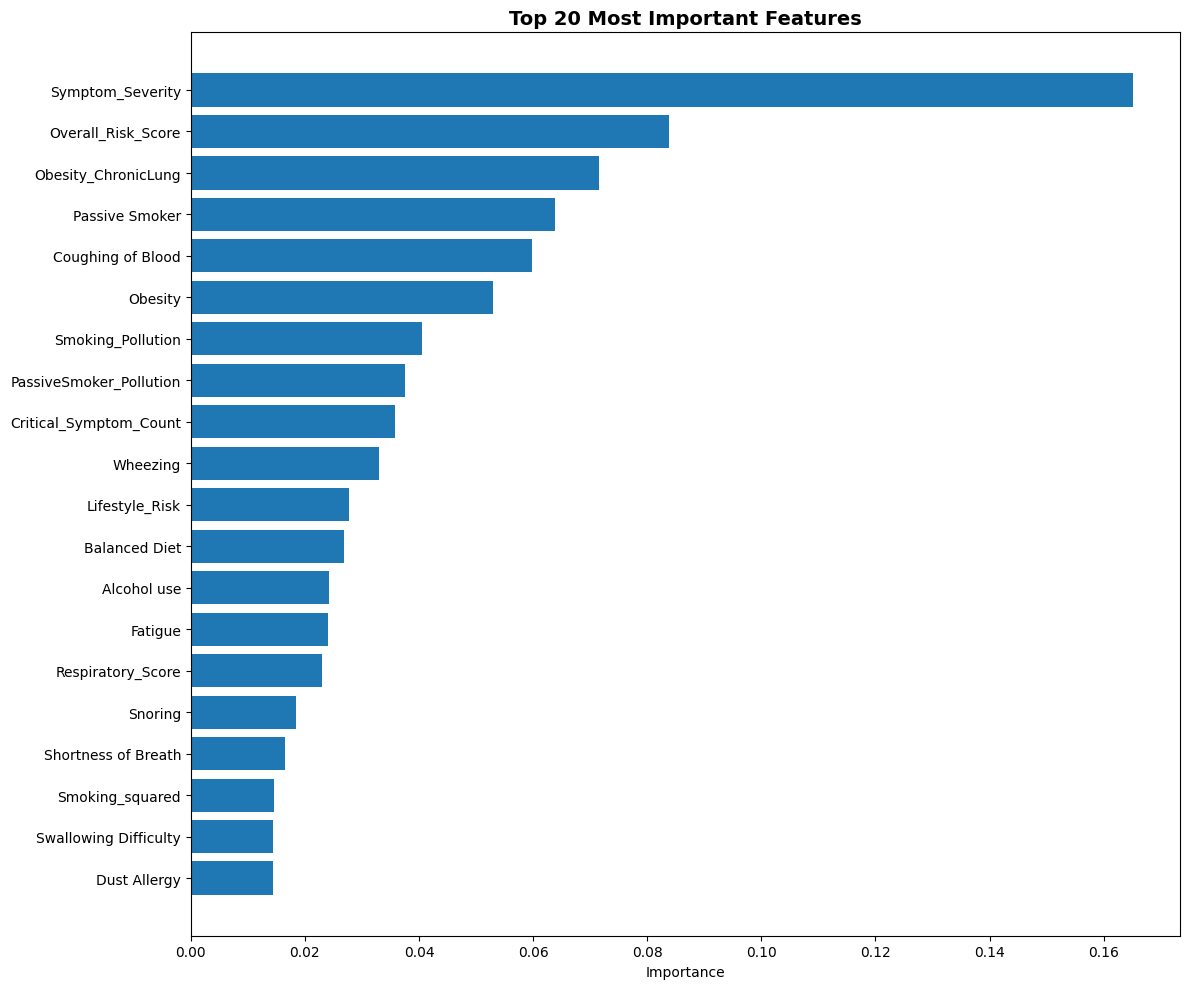

In [13]:
# En iyi 20 özelliği görselleştirelim.

plt.figure(figsize=(12, 10))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()


In [14]:
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

# Toplam özellik önemini bulalım.

In [15]:
features_for_95 = feature_importance[feature_importance['cumulative_importance'] <= 0.95].shape[0]
print(f"\n Features needed for 95% importance: {features_for_95}/{len(feature_cols)}")
features_for_95

# %95 öneme sahip özellikleri bulalım.


 Features needed for 95% importance: 29/41


29

In [16]:
# 3. ÖZELLİK SEÇİMİ - EN İYİ K ÖZELLİKLERİ

# Farklı sayıda özelliği test edelim.

k_values = [10, 15, 20, 25, 30, len(feature_cols)]
results = []

print("\n Testing different feature counts...")

for k in k_values:
    if k > len(feature_cols):
        continue
    
    # Select top k features
    top_k_features = feature_importance.head(k)['feature'].tolist()
    X_train_k = X_train[top_k_features]
    X_test_k = X_test[top_k_features]
    
    # Scale
    scaler_k = StandardScaler()
    X_train_k_scaled = scaler_k.fit_transform(X_train_k)
    X_test_k_scaled = scaler_k.transform(X_test_k)
    
    # Train model
    model_k = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
    model_k.fit(X_train_k_scaled, y_train)
    
    # Evaluate
    train_acc = model_k.score(X_train_k_scaled, y_train)
    test_acc = model_k.score(X_test_k_scaled, y_test)
    cv_score = cross_val_score(model_k, X_train_k_scaled, y_train, cv=5).mean()
    
    results.append({
        'Feature_Count': k,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'CV_Score': cv_score,
        'Overfitting': train_acc - test_acc
    })
    
    print(f"   k={k:3d}: Test Acc = {test_acc:.4f}, CV = {cv_score:.4f}")

results_df = pd.DataFrame(results)
print("\n Feature Selection Results:")
print(results_df.to_string(index=False))

# Find optimal k (best CV score with minimal overfitting)
results_df['score_metric'] = results_df['CV_Score'] - results_df['Overfitting'] * 0.5
optimal_k = results_df.loc[results_df['score_metric'].idxmax(), 'Feature_Count']
optimal_test_acc = results_df.loc[results_df['score_metric'].idxmax(), 'Test_Accuracy']

print(f"\n OPTIMAL FEATURE COUNT: {int(optimal_k)}")
print(f"   Test Accuracy: {optimal_test_acc:.4f}")



 Testing different feature counts...
   k= 10: Test Acc = 1.0000, CV = 1.0000
   k= 15: Test Acc = 1.0000, CV = 1.0000
   k= 20: Test Acc = 1.0000, CV = 1.0000
   k= 25: Test Acc = 1.0000, CV = 1.0000
   k= 30: Test Acc = 1.0000, CV = 1.0000
   k= 41: Test Acc = 1.0000, CV = 1.0000

 Feature Selection Results:
 Feature_Count  Train_Accuracy  Test_Accuracy  CV_Score  Overfitting
            10             1.0            1.0       1.0          0.0
            15             1.0            1.0       1.0          0.0
            20             1.0            1.0       1.0          0.0
            25             1.0            1.0       1.0          0.0
            30             1.0            1.0       1.0          0.0
            41             1.0            1.0       1.0          0.0

 OPTIMAL FEATURE COUNT: 10
   Test Accuracy: 1.0000


In [24]:
# 5. SON ÖZELLİK SETİ

final_features = feature_importance.head(int(optimal_k))['feature'].tolist()

print(f"\n Recommended Feature Set ({int(optimal_k)} features):")
for i, feat in enumerate(final_features, 1):
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    print(f"   {i:2d}. {feat:35s} (importance: {imp:.4f})")


 Recommended Feature Set (10 features):
    1. Symptom_Severity                    (importance: 0.1651)
    2. Overall_Risk_Score                  (importance: 0.0838)
    3. Obesity_ChronicLung                 (importance: 0.0715)
    4. Passive Smoker                      (importance: 0.0638)
    5. Coughing of Blood                   (importance: 0.0598)
    6. Obesity                             (importance: 0.0529)
    7. Smoking_Pollution                   (importance: 0.0405)
    8. PassiveSmoker_Pollution             (importance: 0.0376)
    9. Critical_Symptom_Count              (importance: 0.0358)
   10. Wheezing                            (importance: 0.0330)


In [25]:
# 6. İŞ GEREKSİNİMLERİNİN KONTROLÜ

# İş perspektifinden kritik özellikleri tanımlayalım.

business_critical_features = [
    'Smoking', 'Age', 'Genetic Risk', 'Air Pollution',
    'Chest Pain', 'Coughing of Blood', 'Shortness of Breath',
    'chronic Lung Disease'
]

print("\n🔍 Checking critical features in final set:")
missing_critical = []
for feat in business_critical_features:
    if feat in final_features:
        print(f"   ✅ {feat}")
    else:
        print(f"   ⚠️ {feat} - NOT IN FINAL SET")
        missing_critical.append(feat)

if missing_critical:
    print(f"\n⚠️ Missing {len(missing_critical)} critical business features!")
    print("💡 Recommendation: Consider adding these features even if importance is lower...!")
else:
    print("\n✅ All critical business features included!")


🔍 Checking critical features in final set:
   ⚠️ Smoking - NOT IN FINAL SET
   ⚠️ Age - NOT IN FINAL SET
   ⚠️ Genetic Risk - NOT IN FINAL SET
   ⚠️ Air Pollution - NOT IN FINAL SET
   ⚠️ Chest Pain - NOT IN FINAL SET
   ✅ Coughing of Blood
   ⚠️ Shortness of Breath - NOT IN FINAL SET
   ⚠️ chronic Lung Disease - NOT IN FINAL SET

⚠️ Missing 7 critical business features!
💡 Recommendation: Consider adding these features even if importance is lower...!


In [19]:
# 7. MODEL YORUMLANABİLİRLİK ÖZETİ

# Başlıca risk faktörleri:

print("\n🎯 TOP RISK FACTORS (from model):")
print("   These features have highest impact on cancer risk prediction:")
for i, feat in enumerate(feature_importance.head(5)['feature'], 1):
    print(f"   {i}. {feat}")


🎯 TOP RISK FACTORS (from model):
   These features have highest impact on cancer risk prediction:
   1. Symptom_Severity
   2. Overall_Risk_Score
   3. Obesity_ChronicLung
   4. Passive Smoker
   5. Coughing of Blood


In [20]:
# Özellik kategorileri:

print("\n FEATURE CATEGORIES IN FINAL SET:")
categories = {
    'Lifestyle': ['Smoking', 'Alcohol', 'Obesity', 'Balanced Diet'],
    'Environmental': ['Air Pollution', 'Dust Allergy', 'OccuPational Hazards'],
    'Genetic/Medical': ['Genetic Risk', 'chronic Lung Disease'],
    'Symptoms': ['Chest Pain', 'Coughing of Blood', 'Fatigue', 'Weight Loss', 
                'Shortness of Breath', 'Wheezing'],
    'Engineered': [f for f in final_features if any(x in f for x in 
                ['Risk', 'Score', 'Level', 'Interaction', 'squared', 'Group'])]
}

for category, features in categories.items():
    count = sum(1 for f in features if f in final_features)
    print(f"   {category:20s}: {count} features")



 FEATURE CATEGORIES IN FINAL SET:
   Lifestyle           : 1 features
   Environmental       : 0 features
   Genetic/Medical     : 0 features
   Symptoms            : 2 features
   Engineered          : 1 features


In [21]:
# 8. SONUÇLARI KAYDET

# Özellik önemini kaydedelim.

feature_importance.to_csv('../data/processed/feature_importance.csv', index=False)
print(" Feature importance saved: feature_importance.csv")


# Son özellik setini kaydet

with open('final_feature_set.txt', 'w', encoding='utf-8') as f:
    f.write(f"FINAL FEATURE SET ({int(optimal_k)} features)\n")
    f.write("="*80 + "\n\n")
    for i, feat in enumerate(final_features, 1):
        imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
        f.write(f"{i:2d}. {feat:35s} (importance: {imp:.6f})\n")
    
    f.write("\n\nBUSINESS CRITICAL FEATURES CHECK:\n")
    f.write("="*80 + "\n")
    for feat in business_critical_features:
        status = "✅ INCLUDED" if feat in final_features else "⚠️ MISSING"
        f.write(f"{feat:35s}: {status}\n")

print("✅ Final feature set saved: final_feature_set.txt")

 Feature importance saved: feature_importance.csv
✅ Final feature set saved: final_feature_set.txt


In [22]:
# Özellik seçimi sonuçlarını kaydedelim.

results_df.to_csv('feature_selection_results.csv', index=False)
print("✅ Feature selection results saved: feature_selection_results.csv")

print("\n" + "="*80)
print("MODEL EVALUATION COMPLETED! ✅")
print("="*80)
print(f"\n🎯 Recommended: Use {int(optimal_k)} features for optimal performance")
print(f"📊 Expected Test Accuracy: {optimal_test_acc:.4f}")

✅ Feature selection results saved: feature_selection_results.csv

MODEL EVALUATION COMPLETED! ✅

🎯 Recommended: Use 10 features for optimal performance
📊 Expected Test Accuracy: 1.0000
